In [86]:
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''

In [87]:
run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar -l")

'avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan\nMy log: initialize /tmp/fileXaqio7, this=0x7fc3400789a0 with dump_freq=0\n'

In [88]:
# Functional workloads
dacapo_workloads = ['sunflow', 'pmd', 'avrora', 'fop', 'luindex', 'lusearch', 'lusearch-fix']

# Commands to run
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/renaissance-gpl-0.14.2.jar -r 1 future-genetic

In [89]:
# run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=10 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow")

In [90]:
# run_cmd("find /tmp/ -maxdepth 1 -size +100b -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")

In [27]:
# logs reader

import datetime
import os

class ObjectCnt:
    def __init__(self, **kwargs) -> None:
        self.__dict__.update(kwargs)

    def __repr__(self):
        return "ObjectCnt(thread=%d, cls=%s, ptr='%s', cnt=%d, %s, size=%d, typ='%s')" % (
            self.thread,
            self.cls,
            self.ptr,
            self.cnt,
            '' if self.length is None else ('length=%d' % self.length),
            self.size,
            self.typ
        )


def cur_timestamp():
    current_timestamp = datetime.datetime.now()
    return current_timestamp.strftime("%Y-%m-%d %H:%M:%S")


def reverse_readline(filename, buf_size=8192):
    with open(filename, 'r') as fh:
        segment = None
        offset = 0
        fh.seek(0, os.SEEK_END)
        file_size = remaining_size = fh.tell()
        while remaining_size > 0:
            offset = min(file_size, offset + buf_size)
            fh.seek(file_size - offset)
            buffer = fh.read(min(remaining_size, buf_size))
            remaining_size -= buf_size
            lines = buffer.split('\n')

            if segment is not None:
                if buffer[-1] != '\n': lines[-1] += segment
                else: yield segment
            
            segment = lines[0]
            for index in range(len(lines) - 1, 0, -1):
                if lines[index]:
                    yield lines[index]

        if segment is not None:
            yield segment


def read_line(filename):
    with open(filename, 'r') as file:
        for line in file:
            yield line


def add_snapshot(snapshots, snap, last_n):
    snapshots.append(snap)
    if last_n and len(snapshots) > last_n:
        snapshots = snapshots[1:]
    return snapshots


def count_number_of_dumps(logfile):
    snapshots_cnt = 0
    file_lines = reverse_readline(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            snapshots_cnt += 1

    return snapshots_cnt


def read_logs(logfile, last_n = None, verbose=False, reversed=False, generator=False):
    if last_n is None: last_n = sys.maxint
    snapshots = []
    cur_dict = set()
    snapshots_cnt = 0

    file_lines = reverse_readline(logfile) if reversed else read_line(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            if len(cur_dict) == 0: continue

            snapshots_cnt += 1

            if generator:
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
                if snapshots_cnt == last_n:
                    break
            else:
                snapshots = add_snapshot(snapshots, cur_dict, last_n)
                if reversed and len(snapshots) == last_n:
                    break
            
            cur_dict = set()
        elif 'Skipping Snapshot' not in line:
            # My log: th=172166293241342555, class=[B, ptr=0x60d1df368, cnt=64
            assert 'My log' in line, ('unexpected line format for ' + line)
            parts = line.split(', ')

            th_str = parts[0]
            if th_str.startswith('My log array:'): typ = 'array'
            elif th_str.startswith('My log obj:'): typ = 'object'
            else: assert False, ('unexpected log format for ' + th_str)

            tup = ObjectCnt(
                thread = int(th_str[th_str.find('th=') + len('th='):]),
                cls = parts[1][len('class='):],
                ptr = parts[2][len('ptr='):],
                cnt = int(parts[3][len('cnt='):]),
                length = (None if typ == 'object' else int(parts[-2][len('len='):])),
                size = int(parts[-1][len('size='):]),
                typ = typ)
            
            cur_dict.add(tup)

    if len(cur_dict) > 0:
        if generator:
            if snapshots_cnt != last_n:
                snapshots_cnt += 1
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
        else:
            snapshots = add_snapshot(snapshots, cur_dict, last_n)

    if reversed and not generator:
        snapshots = snapshots[::-1]

    # print(snapshots)
    if verbose:
        print(cur_timestamp(), 'Got %d snapshots for the file=%s' % (snapshots_cnt, logfile))
        if not generator:
            for idx, snap in enumerate(snapshots):
                print('Snapshot #%d with size=%d' % (idx, len(snap)))

    if not generator:
        return snapshots

In [8]:
# logs/images saver

import matplotlib.backends.backend_pdf
import numpy as np
import matplotlib.pyplot as plt
import os

def display_freq_bins(objects, group_by_sizes=True, file=None, init_file=None, iteration=None, dynamic_bins_size=True):
    # Extract the access counts and sizes from the object counts
    access_counts = np.array([obj.cnt for obj in objects])
    object_sizes = np.array([obj.size for obj in objects])

    # Step 1: Create bins to group the access counts automatically
    num_bins = 10  # Adjust the number of bins as needed

    if dynamic_bins_size:
        # Calculate bin edges based on quantiles
        bin_edges = np.percentile(access_counts, np.linspace(0, 100, num_bins + 1))
    else:
        bin_edges = np.histogram_bin_edges(access_counts, bins=num_bins)

    # Step 2: Calculate the total size and object count for each bin
    total_sizes = np.zeros(num_bins, dtype=int)
    total_object_counts = np.zeros(num_bins, dtype=int)

    for i in range(num_bins):
        mask = (access_counts >= bin_edges[i]) & (access_counts < bin_edges[i + 1])

        total_sizes[i] = np.sum(object_sizes[mask])
        total_object_counts[i] = np.sum(mask)

    if group_by_sizes: y_axis = total_sizes
    else: y_axis = total_object_counts
    # print(y_axis)

    display_iteration = ' #' + str(iteration) if iteration is not None else ''

    # Step 3: Display the histogram
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    plt.bar(range(num_bins), y_axis, width=0.8, align='center')
    plt.xlabel("Bins of Access Counts")
    if group_by_sizes: plt.ylabel("Size of Objects")
    else: plt.ylabel("Number of Objects")
    plt.title("Histogram of Objects by Access Counts%s" % display_iteration)
    plt.xticks(range(num_bins), [f"{int(bin_edges[i])}-{int(bin_edges[i + 1])}" for i in range(num_bins)])
    plt.grid(axis='y')
    plt.yscale('log')

    if init_file:
        file = matplotlib.backends.backend_pdf.PdfPages(init_file) # /tmp/output.pdf

    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Display the total number/size for each bin
    text_output = "Total Number of Objects/Total Size for Each Bin %s:\n" % display_iteration
    for i in range(num_bins):
        text_output += f"Bin {int(bin_edges[i])}-{int(bin_edges[i + 1])}: {total_object_counts[i]} objects, {int(total_sizes[i]/1024)} Kb\n"

        
    if file:
        plt.text(0.1, 0.5, text_output, fontsize=12, ha='left', va='center')
        plt.axis('off')

        file.savefig(plt.gcf())
        plt.close()
        if init_file:
            file.close()

    else:
        print(text_output)


def replace_extension(file_path, new_extension):
    base_path, _ = os.path.splitext(file_path)
    new_file_path = base_path + new_extension
    return new_file_path


def process_store_dump(file, last_n, reversed=False):
    snapshots = read_logs(file, last_n=last_n, verbose=True)

    new_file_path = replace_extension(file, '.pdf')
    pdf = matplotlib.backends.backend_pdf.PdfPages(new_file_path)
    for idx, snap in enumerate(read_logs(file, last_n=last_n, verbose=True, generator=True, reversed=reversed)):
        if reversed: idx = - (idx + 1)
        display_freq_bins(snap, file=pdf, iteration=idx)
    pdf.close()
    return snapshots

In [9]:
# file = '/home/hpylypets-ua/Documents/University/research_jvm/results/sunflow/run3/dump_filewrJoPj'
# file = '/home/savitar/research_jvm/results/h2/run1/dump_filel4cjsR'
# snapshots = read_logs(file, last_n=2, verbose=True)
# display_freq_bins(snapshots[1], init_file='/tmp/output.pdf')

In [26]:
# file = '/home/savitar/research_jvm/results/sunflow/run5/dump_fileo3CZLt'
# for snap in read_logs(file, last_n=2, verbose=True, generator=True, reversed=True):
#     print('Got a guy')

Snapshot #0 with size=59175
Got a guy
Snapshot #1 with size=133443
Got a guy
2023-08-12 16:00:20 Got 2 snapshots for the file=/home/savitar/research_jvm/results/sunflow/run5/dump_fileo3CZLt


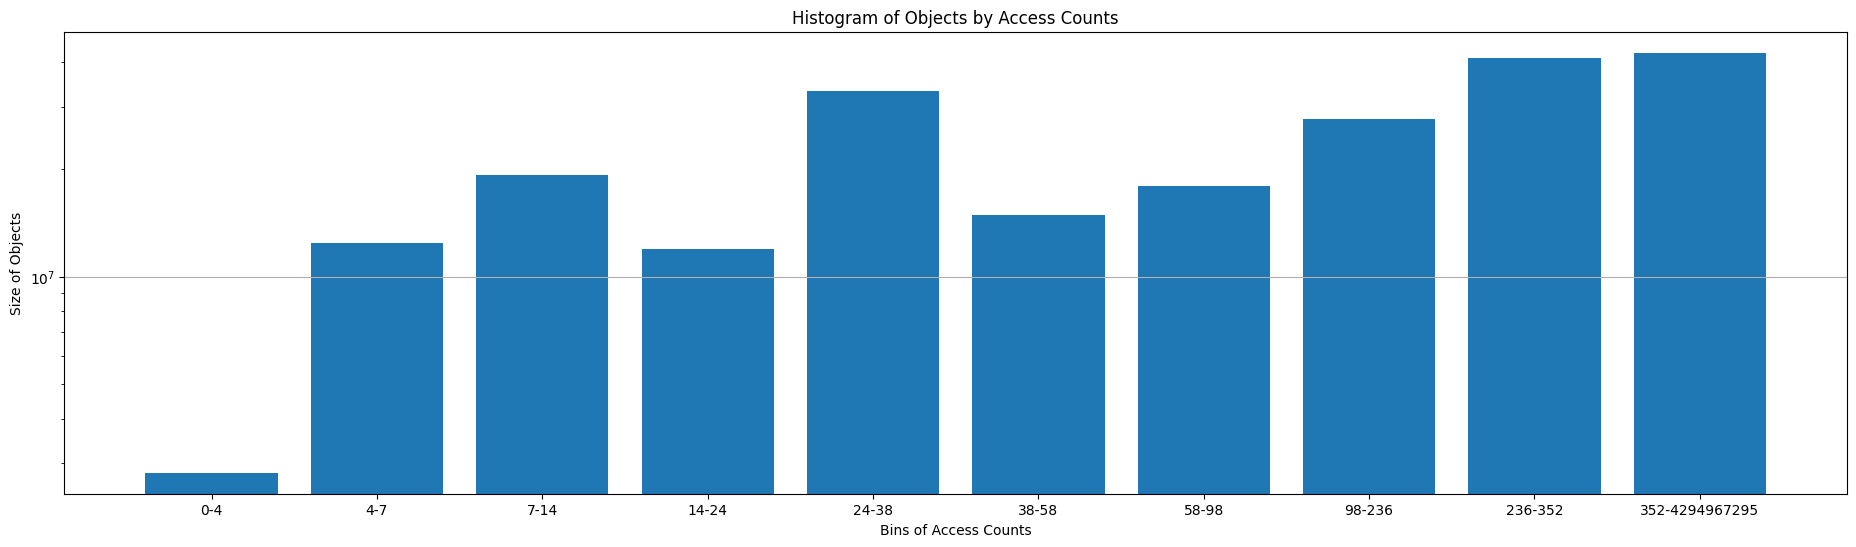

Total Number of Objects for Each Bin :
Bin 0-4: 92547 objects
Bin 4-7: 769331 objects
Bin 7-14: 721124 objects
Bin 14-24: 390325 objects
Bin 24-38: 710129 objects
Bin 38-58: 566169 objects
Bin 58-98: 540168 objects
Bin 98-236: 546134 objects
Bin 236-352: 540417 objects
Bin 352-4294967295: 540492 objects



In [22]:
# snap = snapshots[1]
# display_freq_bins(snap)

In [94]:
# pdf = matplotlib.backends.backend_pdf.PdfPages("/tmp/output.pdf")
# generator = True
# for idx, snap in enumerate(read_logs(file, last_n=100, verbose=True, generator=generator, reversed=True)):
#     idx = (-idx-1) if generator else idx
#     display_freq_bins(snap, file=pdf, iteration=idx)
# pdf.close()

In [14]:
# The flow

# Run workflow scenario - pick one of dacapo workloads and execute with run_cmd. let it be luindex
# Find files involved in GC stuff - find command with file_ greater than 100b
# Analyze each of the files to get a sequence of snapshots for each of which build a histogram of total object size for each access count bucket. Also, exclude anomaly data
# Store the results in the file in a format "benchmark/simulation/runX"
# Build for all the snapshots at this stage, but eventually we shouldn't pick more than 10
# Cleanup to remove the file* from /tmp

import os
import shutil
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''


OUTPUT_DIR = '/home/savitar/research_jvm/results/'


def file_is_dump(file):
    return os.path.getsize(file) > 100


def run_iteration(iter=0, run_benchmark=True, cleanup=True, last_n=100, dump_period=10, benchmark='luindex', copy_files=True):
    print(cur_timestamp(), 'Running iteration #{} with args={}'.format(iter, locals()))

    # cleanup
    if cleanup:
        print(cur_timestamp(), 'Cleanup')
        run_cmd("rm -f /tmp/file*")

    if not copy_files: run_benchmark = False
    
    if run_benchmark:
        cmd = f"~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq={dump_period} -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar {benchmark}" # sunflow
        print(cur_timestamp(), "Executing benchmark:", cmd)
        run_cmd(cmd)

    iteration_dir = os.path.join(OUTPUT_DIR, benchmark, 'run%d' % iter)

    if copy_files:
        if os.path.exists(iteration_dir):
            shutil.rmtree(iteration_dir)
        os.makedirs(iteration_dir)

        # copy all files first
        print(cur_timestamp(), 'Copying all the files to the %s' % iteration_dir)
        found_files = run_cmd("find /tmp/ -maxdepth 1 -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")
        copied_dump_files = []
        if found_files:
            found_files = found_files.splitlines()
            
            for file in found_files:
                is_dump = file_is_dump(file)

                basename = os.path.basename(file)
                if is_dump:
                    basename = 'dump_' + basename

                file_name = os.path.join(iteration_dir, basename)
                shutil.copy(file, file_name)

                if is_dump:
                    copied_dump_files.append(file_name)
    else:
        # pick up files from the directory
        found_files = run_cmd("find '%s' -maxdepth 1 -type f -name 'dump_*' ! -name '*.*'" % iteration_dir)
        copied_dump_files = []
        if found_files:
            copied_dump_files = found_files.splitlines()

    print(cur_timestamp(), 'Got {} files: {}'.format(len(copied_dump_files), copied_dump_files))

    # analyze dumps
    print(cur_timestamp(), 'Processing and storing %d dumps' % len(copied_dump_files))
    if copied_dump_files:
        for dump_file in copied_dump_files:
            process_store_dump(dump_file, last_n=last_n)

    print()

In [21]:
run_iteration(1, last_n=100, dump_period=10, benchmark='h2')
#  ['sunflow', 'pmd', 'avrora', 'fop', 'luindex', 'lusearch', 'lusearch-fix']

2023-08-10 16:42:56 Running iteration #1 with args={'iter': 1, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 10, 'benchmark': 'h2'}
2023-08-10 16:42:56 Cleanup
2023-08-10 16:42:56 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=10 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar h2
2023-08-10 16:58:34 Copying all the files to the /home/savitar/research_jvm/results/h2/run1
2023-08-10 16:58:44 Processing and storing 1 dumps


In [23]:
# file = '/home/savitar/research_jvm/results/sunflow/run5/dump_fileo3CZLt'
# process_store_dump(file, last_n=100, reversed=False)
# print(count_number_of_dumps(file))

Adding a snapshot # 0
Adding a snapshot # 1
Adding a snapshot # 2
Adding a snapshot # 3


In [11]:
def run_workflow(benchmark='sunflow', num=15, copy_files=True, dump_period=5, last_n=100):
    for iter in range(num):
        try:
            run_iteration(iter, last_n=last_n, dump_period=dump_period, benchmark=benchmark, copy_files=copy_files)
        except Exception as ex:
            print('Iteration failed with', ex)

In [12]:
# run_iteration(benchmark='sunflow (copy)', iter=2, copy_files=False)
# run_workflow(benchmark='h2 (copy)', num=1, copy_files=False, last_n=100)

2023-08-10 15:28:47 Running iteration #0 with args={'iter': 0, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 5, 'benchmark': 'sunflow'}
2023-08-10 15:28:47 Cleanup
2023-08-10 15:28:47 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=5 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
2023-08-10 15:30:20 Copying all the files to the /home/savitar/research_jvm/results/sunflow/run0
2023-08-10 15:30:20 Processing and storing 1 dumps
2023-08-10 15:30:33 Got 16 snapshots for the file=/home/savitar/research_jvm/results/sunflow/run0/dump_fileSScs3j
Snapshot #0 with size=23122
Snapshot #1 with size=185676
Snapshot #2 with size=217253
Snapshot #3 with size=220724
Snapshot #4 with size=214849
Snapshot #5 with size=228339
Snapshot #6 with size=228014
Snapshot #7 with size=237228
Snapshot #8 with size=234558
Snapshot #9 with size=231541
Snapshot #10 with size=226270
Snapshot #11 with size